Uma explicação mais completa está em: https://www.tensorflow.org/tutorials/images/transfer_learning

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [2]:
#Extraindo, da URL, o dataset com dados de treino (1k imagens de gato e 1k, de cachorro) e validação
# (500 imagens de fato e 500, de cachorro)
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

68606236/68606236 [==============================] - 13s 0us/step


In [3]:
#Criando um data set para treino e validação.
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

#Então, serão 2k arquivos com 2 classes no dataset de treino e 1k no de validação. 

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


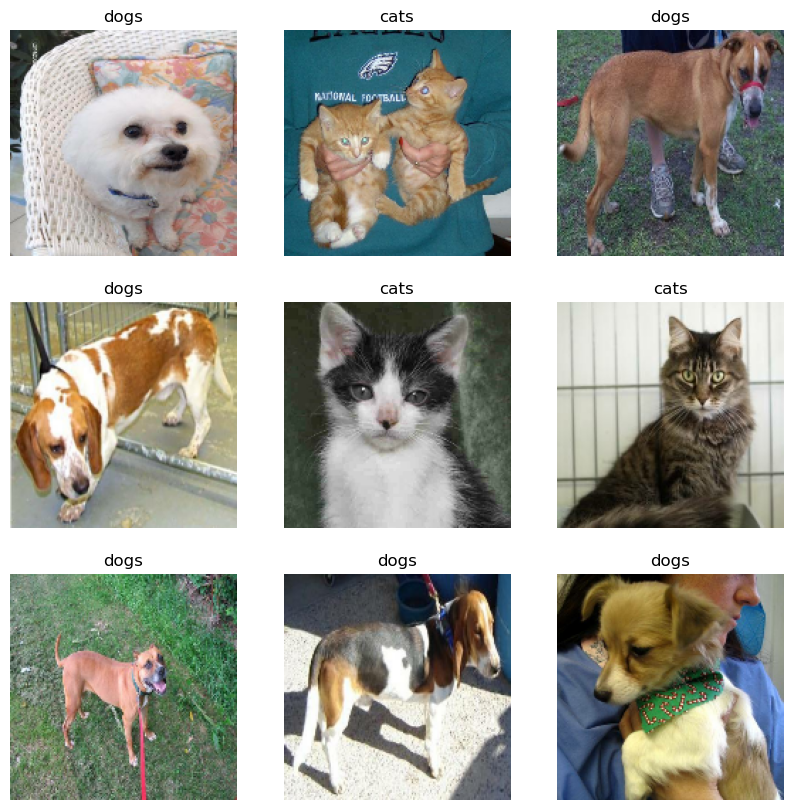

In [4]:
# Criando um laço para mostrar as primeiras nove imagens e rótulos do conjunto de treinamento:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
# Como o conjunto de dados original não contém um conjunto de teste, vamos criar um. Para fazer isso,
# determinaremos quantos lotes de dados estão disponíveis no conjunto de validação usando
# tf.data.experimental.cardinality e movendo 20% deles para um conjunto de teste. (era 32 e ficou 26 e 6)

val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [6]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [7]:
# Configurar o conjunto de dados para desempenho
# Use a pré-busca em buffer para carregar imagens do disco sem que a E/S se torne um bloqueio.
# Ou seja, como estamos trabalhando com o transfer_learning, vamos trazer os datasets e fazer um
# autotune (afinar automaticamente) das features.

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [9]:
# Usar o aumento de dados
# Quando você não tem um grande conjunto de dados de imagem, é uma boa prática introduzir artificialmente
# a diversidade de amostra aplicando transformações aleatórias, porém realistas, às imagens de treinamento,
# como rotação e inversão horizontal. Isso ajuda a expor o modelo a diferentes aspectos dos dados de treinamento
# e reduzir o overfitting .


data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

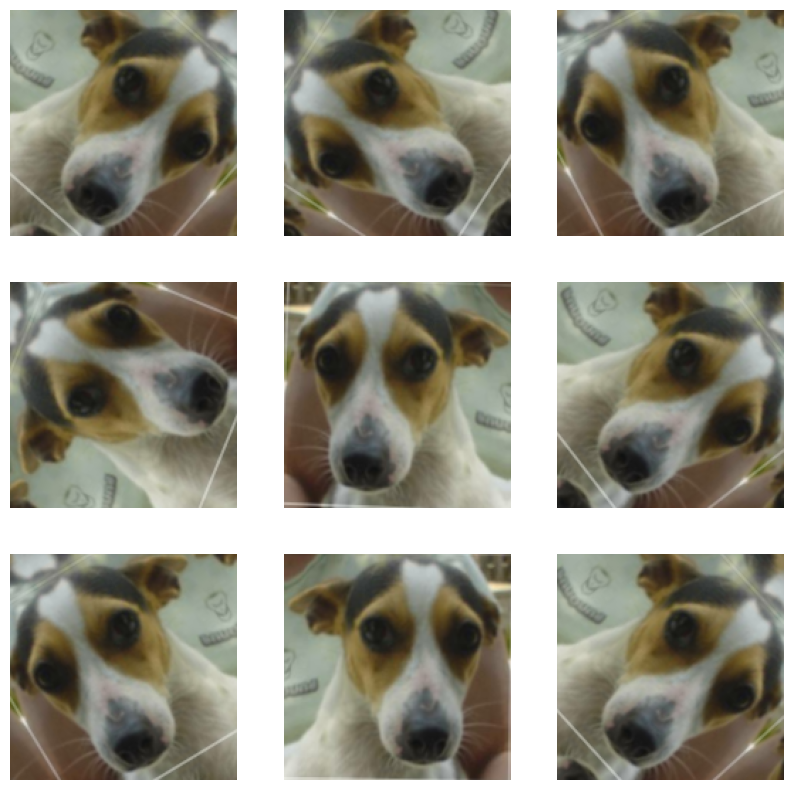

In [10]:
# Agora vamos aplicar repetidamente essas camadas na mesma imagem acima e ver o resultado.
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [12]:
# Redimensionar valores de pixel.
# Faremos o download do modelo base do google (tf.keras.applications.MobileNetV2).

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [13]:
# O modelo foi pré-treinado com valores de pixel em [-1, 1] , mas neste ponto, os valores de pixel das imagens
# baixadas estão em [0, 255] . Para redimensioná-los, usaremos o método de pré-processamento incluído no modelo.

rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [14]:
# Criaremos agora o modelo base a partir do modelo MobileNet V2 desenvolvido no Google. 
# Ele foi pré-treinado no com um grande conjunto de dados que consiste em 1,4 milhão de imagens e 1.000 classes.

# ImageNet é um conjunto de dados de treinamento de pesquisa com uma ampla variedade de categorias, 
# como jackfruit e syringe . Essa base de conhecimento nos ajudará a classificar cães e gatos de nosso
# conjunto de dados específico.

# Primeiro, precisamos escolher qual camada do MobileNet V2 usaremos para extrair os recursos.
# A última camada de classificação não é muito útil (como o sentido é de baixo pra cima, a camada top é a última).
# Em vez disso, iremos até a camada antes da operação de nivelamento ("camada de gargalo").
# Os recursos da camada de gargalo retêm mais generalidade em comparação com a camada final/superior.

# Então, primeiro, instanciaremos um modelo MobileNet V2 pré-carregado com pesos treinados no ImageNet.
# Ao especificar o argumento include_top=False, estamos carregando uma rede que não inclui as camadas de
# classificação na parte superior, o que é ideal para extração de recursos.


# Então vamos pra criação do modelo base a partir do modelo MobileNet V2 desenvolvido no Google.
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 2s 0us/step


In [15]:
# Este extrator de recursos converte cada imagem de 160x160x3 em um bloco de recursos de 5x5x1280.
# Vamos ver o que ele faz com um exemplo de lote de imagens:


image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [16]:
# Extração de recursos
# Nesta etapa, congelaremos a base convolucional criada na etapa anterior e usaremos como extrator de recursos.
# Além disso, adicionaremos um classificador em cima dele e treinaremos o classificador de nível superior.

# Portanto, vamos ao congelamento da base convolucional.
# É importante congelar a base convolucional antes de compilar e treinar o modelo.
# O congelamento (definindo layer.trainable = False) evita que os pesos em uma determinada
# camada sejam atualizados durante o treinamento. O MobileNet V2 tem muitas camadas, portanto,
# definir o sinalizador trainable de todo o modelo como False irá congelar todas elas.

base_model.trainable = False

# Nota importante sobre camadas de BatchNormalization
# Muitos modelos contêm camadas tf.keras.layers.BatchNormalization. Essa camada é um caso especial
# e precauções devem ser tomadas no contexto do ajuste fino.
# Quando se define layer.trainable = False, a camada BatchNormalization será executada no
# modo de inferência e não atualizará suas estatísticas de média e variação.

# Quando descongelamos um modelo que contém camadas BatchNormalization para fazer o ajuste fino,
# você deve manter as camadas BatchNormalization no modo de inferência passando training = False ao
# chamar o modelo base. Caso contrário, as atualizações aplicadas aos pesos não treináveis ​​destruirão
# o que o modelo aprendeu.

In [17]:
# Vamos criar uma sumarização do modelo base
base_model.summary()

# temos a camada de input, com imagens de 160x160 pixels, em 3 camadas de RGB;
# Uma outra de convolução;
# de batchnormalization que é convolução;
# uma de convolução com ativação do tipo ReLU;
# e por aí vai.

# atentar que são mais de 2milhões de parâmetros, e todos não treináveis.
# Não faz sentido nenhum treinar tudo de novo. 


Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [18]:
# Adicionando um cabeçalho de classificação
# Para gerar previsões a partir do bloco de feições, calcula-se a média das localizações espaciais 5x5,
# usando uma camada tf.keras.layers.GlobalAveragePooling2D para converter as feições em um único vetor
# de 1280 elementos por imagem.


global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [19]:
# Aplica-se uma camada tf.keras.layers.Dense para converter esses recursos em uma única
# previsão por imagem. Não precisamos de uma função de ativação aqui porque essa previsão
# será tratada como um logit ou um valor bruto de previsão. Números positivos predizem a
# classe 1, números negativos predizem a classe 0.


prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [20]:
# Constrói-se um modelo encadeando as camadas de aumento de dados, redimensionamento,
# base_model e extrator de recursos usando a API funcional do Keras. Como mencionado
# anteriormente, usaremos training=False pois nosso modelo contém uma camada BatchNormalization.


inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [21]:
# Compilar o modelo
# Compilaremos o modelo antes de treiná-lo. Como existem duas classes, usaremos a perda
# tf.keras.losses.BinaryCrossentropy com from_logits=True, pois o modelo fornece uma saída linear.


base_learning_rate = 0.0001     # O rate é bem mais baixo que o comum pois a base já está treinada.
                                # Só há treinamento com os parãmetros novos inseridos
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [22]:
# Os 2,2 milhões de parâmetros no MobileNet estão congelados, mas existem 1,2 mil parâmetros
# treináveis na camada Dense. Estes são divididos entre dois objetos tf.Variable: os pesos e os bias.

len(model.trainable_variables)

2

In [23]:
# Treinar o modelo
# Após treinar por 10 épocas, veremos ~ 94% de precisão no conjunto de validação.

# Aqui vamos avaliar os parâmetros de erro e acurácia antes de aplicar os parâmetros pré-treinados
# no validation_dataset
loss0, accuracy0 = model.evaluate(validation_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

26/26 [==============================] - 19s 558ms/step - loss: 0.8265 - accuracy: 0.4975
initial loss: 0.83
initial accuracy: 0.50


In [24]:
initial_epochs = 10

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

# Repare que as métricas de validação são claramente melhores do que as métricas de treinamento.
# O principal fator é porque camadas como tf.keras.layers.BatchNormalization e tf.keras.layers.Dropout afetam
# a precisão durante o treinamento. Eles são desativados ao calcular a perda de validação.

# Em menor grau, também é porque as métricas de treinamento relatam a média de uma época, enquanto
# as métricas de validação são avaliadas após a época, portanto, as métricas de validação veem um modelo
# que foi treinado um pouco mais.

Epoch 1/10
63/63 [==============================] - 59s 813ms/step - loss: 0.6728 - accuracy: 0.6045 - val_loss: 0.5290 - val_accuracy: 0.7191
Epoch 2/10
63/63 [==============================] - 62s 993ms/step - loss: 0.5066 - accuracy: 0.7425 - val_loss: 0.3845 - val_accuracy: 0.8267
Epoch 3/10
63/63 [==============================] - 61s 971ms/step - loss: 0.4192 - accuracy: 0.8005 - val_loss: 0.3037 - val_accuracy: 0.8738
Epoch 4/10
63/63 [==============================] - 56s 897ms/step - loss: 0.3618 - accuracy: 0.8345 - val_loss: 0.2463 - val_accuracy: 0.9134
Epoch 5/10
63/63 [==============================] - 53s 844ms/step - loss: 0.3099 - accuracy: 0.8610 - val_loss: 0.2071 - val_accuracy: 0.9344
Epoch 6/10
63/63 [==============================] - 54s 848ms/step - loss: 0.2833 - accuracy: 0.8730 - val_loss: 0.1818 - val_accuracy: 0.9468
Epoch 7/10
63/63 [==============================] - 56s 895ms/step - loss: 0.2597 - accuracy: 0.8850 - val_loss: 0.1609 - val_accuracy: 0.9554

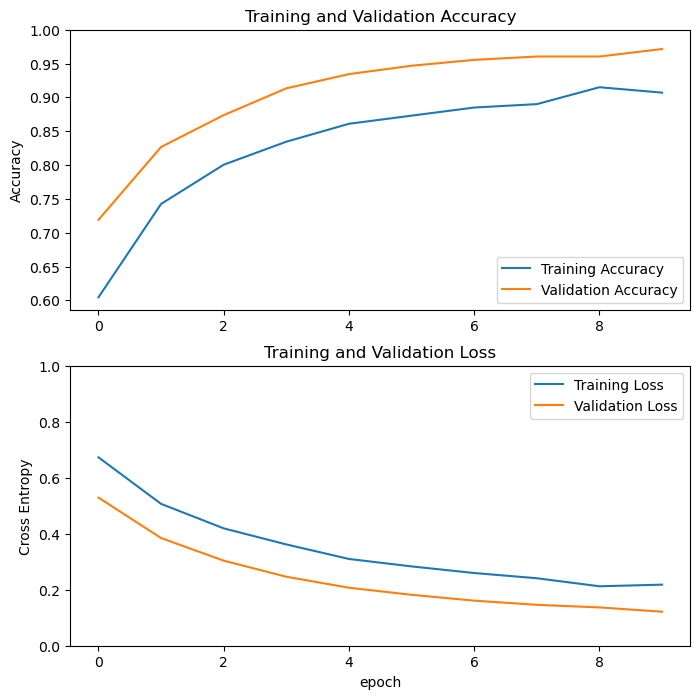

In [25]:
# Curvas de aprendizado
# Vamos dar uma olhada nas curvas de aprendizado da precisão/perda de treinamento e
# validação ao usar o modelo base MobileNetV2 como um extrator de recursos fixo.

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [26]:
# Agora com a base treinada, vamos fazer um ajuste fino do modelo.

# No experimento de extração de recursos, treinamos apenas algumas camadas em cima de um modelo-base MobileNetV2.
# Os pesos da rede pré-treinada não foram atualizados durante o treinamento.

# Uma maneira de aumentar ainda mais o desempenho é treinar (ou "ajustar") os pesos das camadas
# superiores do modelo pré-treinado juntamente com o treinamento do classificador que adicionamos.
# O processo de treinamento forçará os pesos a serem ajustados de mapas de recursos genéricos para
# recursos associados especificamente ao conjunto de dados.

# Observação: isso só deve ser tentado depois de treinar o classificador de nível superior com o modelo
# pré-treinado definido como não treinável. Se adicionarmos um classificador inicializado aleatoriamente
# em cima de um modelo pré-treinado e tentarmos treinar todas as camadas em conjunto, a magnitude das atualizações
# de gradiente será muito grande (devido aos pesos aleatórios do classificador) e nosso modelo pré-treinado irá
# esquecer o que aprendeu.

# Além disso, devemos tentar ajustar um pequeno número de camadas superiores em vez de todo o modelo MobileNet.
# Na maioria das redes convolucionais, quanto mais alta uma camada, mais especializada ela é.
# As primeiras camadas aprendem recursos muito simples e genéricos que se generalizam para quase todos
# os tipos de imagens. À medida em que se sobe, os recursos são cada vez mais específicos para o conjunto
# de dados no qual o modelo foi treinado.
# O objetivo do ajuste fino é adaptar esses recursos especializados para trabalhar com o novo conjunto de dados,
# em vez de substituir o aprendizado genérico.



In [27]:
# Descongelando as camadas superiores do modelo
# Vamos descongelar o base_model e definir as camadas inferiores como não treináveis (vamos deixar
# congeladas as 100 primeiras. As 54 acima serão treinadas).
# Em seguida, vamos recompilar o modelo (necessário para que essas alterações tenham efeito) e
# retomar o treinamento.

base_model.trainable = True

In [28]:
# Descobrindo quantas camadas existem na base_model
print("Number of layers in the base model: ", len(base_model.layers))

# Definindo um limite pra congelamento
fine_tune_at = 100

# Congelando todas as camadas antes da camada "fine_tune_at"
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [29]:
# Compilar o modelo
# Como estamos treinando um modelo muito maior e desejamos readaptar os pesos pré-treinados,
# é importante usar uma taxa de aprendizado menor neste estágio. Caso contrário, o modelo pode
# se ajustar muito rapidamente.


model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [30]:
# Portanto, reduzimos os parâmetros não-treináveis para 400k e subimos os treináveis para 1,9mi
# Vamos verificar a quantidade de variáveis a serem treinadas. Antes eram só 2 (pesos e bias), mas adicionamos
# 154 variáveis que estavam congeladas para o ajuste fino.

len(model.trainable_variables) 

56

In [31]:
# Continue treinando o modelo
# Treinou-se para convergência anteriormente, mas nesta etapa, melhoraremos a precisão em alguns pontos percentuais.


fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs       # então começaremos na época 10, adicionando mais 10 para
                                                        # o ajuste fino.

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 114s 2s/step - loss: 0.1511 - accuracy: 0.9365 - val_loss: 0.0655 - val_accuracy: 0.9691
Epoch 11/20
63/63 [==============================] - 103s 2s/step - loss: 0.1177 - accuracy: 0.9485 - val_loss: 0.0421 - val_accuracy: 0.9864
Epoch 12/20
63/63 [==============================] - 108s 2s/step - loss: 0.1175 - accuracy: 0.9500 - val_loss: 0.0427 - val_accuracy: 0.9851
Epoch 13/20
63/63 [==============================] - 116s 2s/step - loss: 0.0932 - accuracy: 0.9585 - val_loss: 0.0425 - val_accuracy: 0.9839
Epoch 14/20
63/63 [==============================] - 134s 2s/step - loss: 0.0895 - accuracy: 0.9600 - val_loss: 0.0482 - val_accuracy: 0.9851
Epoch 15/20
63/63 [==============================] - 103s 2s/step - loss: 0.0851 - accuracy: 0.9665 - val_loss: 0.0371 - val_accuracy: 0.9790
Epoch 16/20
63/63 [==============================] - 119s 2s/step - loss: 0.0701 - accuracy: 0.9680 - val_loss: 0.0720 - val_accuracy: 0.9802
Epoch 

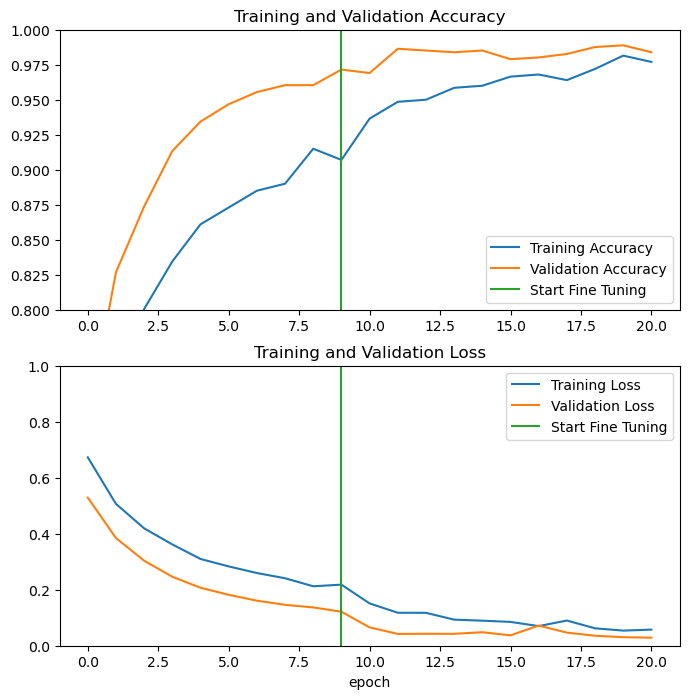

In [32]:
# Vamos dar uma olhada nas curvas de aprendizado da precisão/perda de treinamento e validação ao ajustar
# as últimas camadas do modelo base do MobileNetV2 (camadas superiores) e treinar o classificador em cima dele.

# Se a perda de validação for muito maior do que a perda de treinamento, podemos ter algum overfitting.
# Podemos ter algum overfitting também por conta do novo conjunto de treinamento ser relativamente pequeno
# e semelhante aos conjuntos de dados originais do MobileNetV2.



# Após o ajuste fino, o modelo atinge mais do que 98% de precisão no conjunto de validação.
# Essa reta vertical verde mostra o momento em que começa o ajuste fino (ou seja, a partir da décima época).

acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [33]:
# Avaliação e previsão
# Finalmente, vamos verificar o desempenho do modelo em novos dados usando o conjunto de teste.

# Com esses resultados quase que perfeitos, estamos prontos para prever se o pet é um gato ou um cachorro.

loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 6s 892ms/step - loss: 0.0551 - accuracy: 0.9792
Test accuracy : 0.9791666865348816


Predictions:
 [1 1 1 1 0 1 1 1 1 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0 1 1 0 0 1 1 0 0]
Labels:
 [1 1 1 1 0 1 1 1 1 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0 1 1 0 0 1 1 0 0]


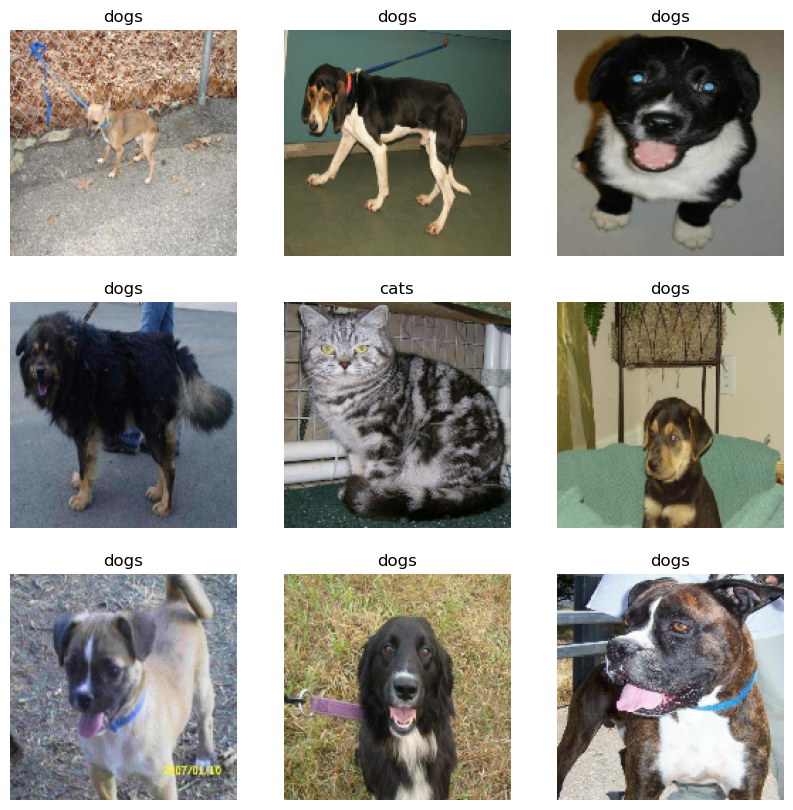

In [34]:
# Recuperando um lote de imagens do dataset de teste
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Aplicando um sigmoid, pois o modelo retorna logits.
# (pra imagem sair correta novamente (de 0 a 255)).
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")